In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import sqlite3
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
from fbprophet import Prophet
pd.set_option('display.max_rows', 500)

In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/chrisschon/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed 

In [2]:
conn = sqlite3.connect('bosh.db')
c = conn.cursor()

In [118]:
nice = ['#a1c9f4',
 '#ffb482',
 '#8de5a1',
 '#ff9f9b',
 '#d0bbff',
 '#debb9b',
 '#fab0e4',
 '#cfcfcf',
 '#fffea3',
 '#b9f2f0']

In [3]:
###PARAMS
item_id = 362
store_id = 1

In [4]:
sales = pd.read_sql(f'select * from sales where item_id = {item_id} and store_id = {store_id}', con = conn)[1000:]

In [5]:
dates = pd.read_sql('select * from dates', con = conn).set_index('date_id')

In [6]:
holidays = pd.read_sql('select * from holidays', con = conn)

In [7]:
sales_df = sales.merge(dates['date_name'], left_on = 'date_id', right_index = True).reset_index()
sales_df['date_name'] = sales_df['date_name'].map(lambda x: pd.to_datetime(x))
sales_df['ds'] = sales_df['date_name']
sales_df['y'] = sales_df['sales_count']
sales_df['log1plusy'] = sales_df['y'].apply(lambda x: np.log(1+x))

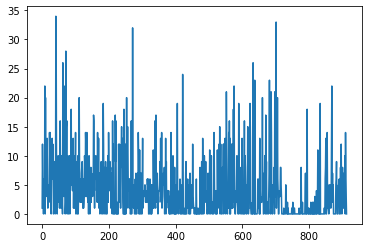

In [8]:
sales_df['sales_count'].plot()

In [146]:
quantiles_list = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

def wpl(y_true, y_pred, tau):
    err = y_true - y_pred
    return np.mean(np.max((tau * err, (tau-1) * err), axis = 0))

class EQModel:
    def __init__(self, x):
        self.x = x
    def fit(self, quantiles_list):
        self.qfit = self.x.quantile(quantiles_list)
        return self.qfit
    def predict(self, q):
        return self.qfit[q]
    def predict_wide(self, q):
        tbl = pd.DataFrame(self.qfit)
        for i in x.index:
            tbl[i] = tbl[self.x.name]
        tbl.drop(self.x.name, axis = 1, inplace = True)
        return(tbl.T)
        

class Series:
    def __init__(self, df, valcol):
        self.df = df
        self.columns = list(df.columns)
        self.valcol = valcol
        self.tseries = pd.Series(df[valcol]).rename('xt')
        self.tseries_normed = (df[valcol] - df[valcol].mean())/df[valcol].std()
        self.logtseries = np.log(2+df[valcol])
        self.length = len(df[valcol])
        self.description = df[valcol].describe()
        
    def plot_series(self, idx_range, **subplkwargs):
        plot_range = idx_range
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(tseries[plot_range])
        
    def plot_forecast(self, history, forecast, forecaste_conf_ints, back = 28, forward = 28, **subplkwargs):
        maxidx = history.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        plot_df = pd.DataFrame(history[-back:].append(forecast)).rename({0:'Sales'}, axis = 1)
        plot_df.loc[forecast.index, 'Type'] = 'Forecast'
        plot_df['Type'].fillna('Historic', inplace = True)
        plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'] = plot_df['Sales'], plot_df['Sales']
        plot_df.loc[forecast.index, 'forecast_conf_int_lower'] = forecast_conf_int['conf_int_lower'].values
        plot_df.loc[forecast.index, 'forecast_conf_int_upper'] = forecast_conf_int['conf_int_upper'].values
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(plot_df[plot_df['Type'] == 'Historic']['Sales'], color = 'black')
        ax.plot(plot_df[plot_df['Type'] == 'Forecast']['Sales'], color = 'green')
        ax.fill_between(plot_df.index, plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'], alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        
    def plot_acf(self, lags = [0,365], **subplkwargs):
        fig, ax = plt.subplots(**subplkwargs)
        autocorrelation_plot(sales[self.valcol], ax = ax)
        ax.set_xlim(lags)
        
    def model_eq(self):
        model = EQModel(self.tseries)
        model_fit = model.fit(quantiles_list)
        return(model, model_fit)
    
    def model_arima(self, data, p=7, d=1, q=0):
        model = ARIMA(data, order=(p,d,q))
        model_fit = model.fit(disp=0)
        return(model, model_fit)
    
    def model_forecast(self, model_fit, forward = 28):
        forecast, forecast_stderr, forecast_conf_int = model_fit.forecast(forward)
        forecast = pd.Series(forecast)
        forecast_stderr = pd.Series(forecast_stderr)
        forecast_conf_int = pd.DataFrame(forecast_conf_int).rename({0:'conf_int_lower', 1:'conf_int_upper'}, axis = 1)
        maxidx = self.tseries.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        self.forecast = forecast
        self.forecast_stderr = forecast_stderr
        self.forecast_conf_int = forecast_conf_int
        return(forecast, forecast_stderr, forecast_conf_int)
    
    def fit_Prophet(self, ds, y, **params):
        country_hols = params.pop('add_country_holidays')
        model = Prophet(**params)
        self.df['y'] = self.df[y]
        self.df['ds'] = self.df[ds]
        if country_hols:
            model.add_country_holidays(country_name=country_hols)
        model.fit(self.df)
        return(model)
    
    def forecast_Prophet(self, model, periods):
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        return(forecast)
    
    def predsamples_Prophet(self, model, forecast):
        ps = model.predictive_samples(forecast)
        return(ps)

    def predsamples_quantiles(self, samples, quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]):
        #expects samples of form given by predsamples_Prophet method
        yhat_samples = samples['yhat']
        yhat_samples_df = pd.DataFrame(yhat_samples, index = np.arange(yhat_samples.shape[0]))
        yhat_samples_qs = yhat_samples_df.quantile(quantiles, axis = 1).T
        return(yhat_samples_qs)
    
    ###PROPHET FUNC

In [147]:
s = Series(sales_df, 'sales_count')

In [150]:
prophparams = {'weekly_seasonality':True, 'add_country_holidays': 'US'}
model = s.fit_Prophet(ds = 'ds', y = 'sales_count', **prophparams)
eqmodel, eqmodel_fit,  = s.model_eq()
eq_preds = eqmodel.predict_wide(s.tseries)
future = model.make_future_dataframe(periods=56)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


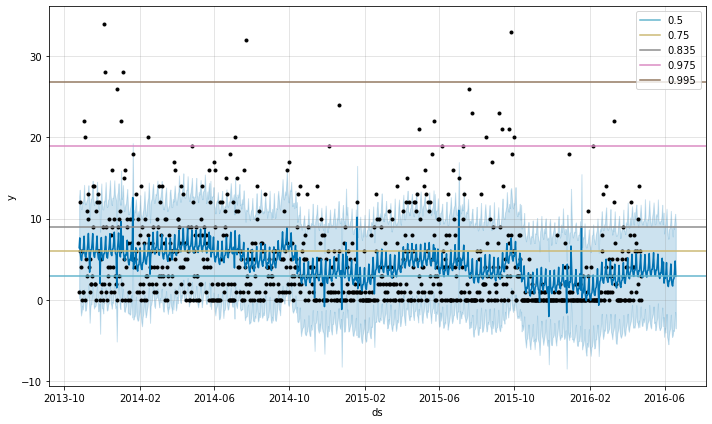

In [152]:
pal = sns.color_palette('deep')
nice = pal.as_hex()
fig, ax = plt.subplots(figsize = (10,6))
model.plot(forecast, ax = ax)
for q, v in eqmodel_fit.iteritems():
    if v > 0:
        ax.axhline(eqmodel_fit[q], label = q, color = nice.pop())
ax.legend(loc = 'upper right')

In [49]:
pred_samples = s.predsamples_Prophet(model, forecast)
quantiles = s.predsamples_quantiles(pred_samples)

In [153]:
y = s.tseries
qtidy = eq_preds.reset_index().melt(id_vars = ['index'],
                                    value_vars = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995],
                                    var_name='quantile', value_name = 'prediction')\
                             .merge(y, left_on = 'index', right_index = True)
qtidy['prediction'] = qtidy['prediction'].map(lambda x: 0 if x < 0 else x)

In [154]:
qtidy['expred'] = np.exp(qtidy['prediction']) - 1

In [161]:
prediction_col = 'prediction'
qtidy['wpl'] = qtidy.apply(lambda x: wpl(x['xt'], x[prediction_col], x['quantile']), axis = 1)
qtidy.head(20)

,index,quantile,prediction,xt,expred,wpl
0,0,0.005,0.00,1,0.000000e+00,0.0050
913,0,0.025,0.00,1,0.000000e+00,0.0250
1826,0,0.165,0.00,1,0.000000e+00,0.1650
2739,0,0.25,0.00,1,0.000000e+00,0.2500
3652,0,0.5,3.00,1,1.908554e+01,1.0000
4565,0,0.75,6.00,1,4.024288e+02,1.2500
5478,0,0.835,9.00,1,8.102084e+03,1.3200
6391,0,0.975,19.00,1,1.784823e+08,0.4500
7304,0,0.995,26.88,1,4.718845e+11,0.1294
1,1,0.005,0.00,12,0.000000e+00,0.0600


In [162]:
qtidy['wpl'].describe()

count    8217.000000
mean        0.889167
std         1.611154
min         0.000000
25%         0.065000
50%         0.375000
75%         1.250000
max        21.000000
Name: wpl, dtype: float64

In [163]:
qtidy['wpl'].sum()

7306.287200000001

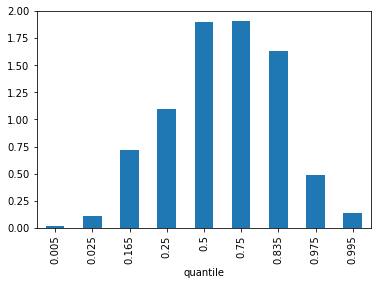

In [164]:
qtidy.groupby('quantile')['wpl'].mean().plot.bar()

In [21]:
qtidy[(qtidy['quantile'] == 0.995) & (qtidy['wpl'] > 1)].sort_values(by = 'sales_count')

,index,quantile,prediction,sales_count,expred,wpl
8546,794,0.995,2.623369,18,12.782077,5.191834
8157,405,0.995,2.770666,19,14.969273,4.010573
8585,833,0.995,2.668526,19,13.418703,5.553391
8620,868,0.995,3.042571,22,19.959050,2.030745
8384,632,0.995,3.061601,26,20.361733,5.610075
7793,41,0.995,3.411259,34,29.303363,4.673153


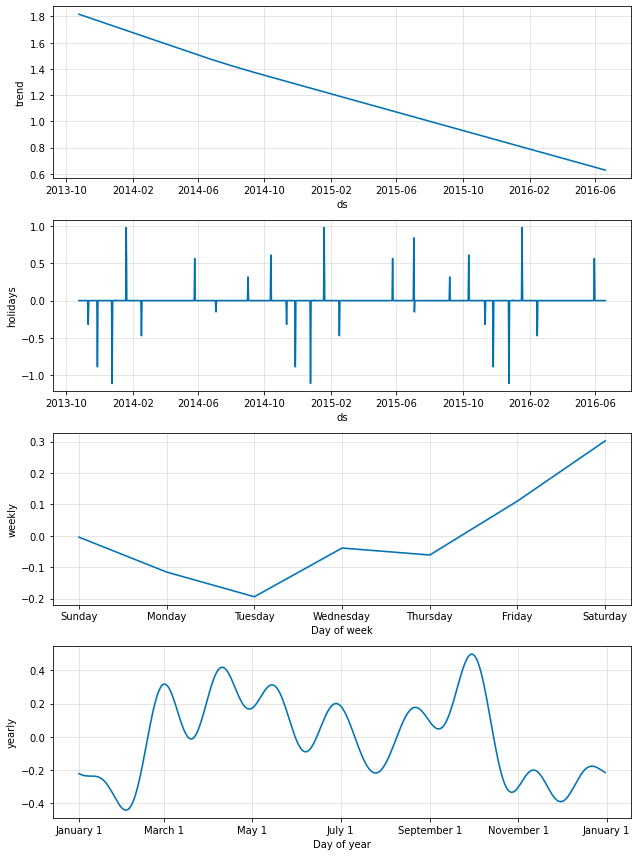

In [22]:
fig = model.plot_components(forecast)